Try AR-SN-HMM on shorter sequence.

In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_sigmoid_normal_observation import ARSigmoidNormalObservation
from ssm_ptc.distributions.sigmoidnormal import SigmoidNormal
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from tqdm import tqdm_notebook as tqdm
import time


In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

In [4]:
traj29.shape

(36000, 4)

In [5]:
def plot_2_mice(data):
    plt.plot(data[:,0], data[:,1], label='virgin')
    plt.plot(data[:,2], data[:,3], label='mother')
    plt.legend();

In [9]:
def plot_4_traces(data):
    plt.plot(data[:, 0], label='x1')
    plt.plot(data[:, 1], label='y1')
    plt.plot(data[:, 2], label='x2')
    plt.plot(data[:, 3], label='y2')
    plt.legend();

In [13]:
arena_xmax = 320
arena_ymax = 370

In [43]:
K = 5
D = 4
T = 36000

bounds = np.array([[-10, arena_xmax + 10], [-10, arena_ymax + 10], [-10, arena_xmax + 10],
                   [-10, arena_ymax + 10]])

#bounds = np.array([[-300, 300], [-300, 300], [-300, 300], [-300, 300]])

In [44]:
tran = LinearTransformation(K=K, D=D, lags=10, use_bias=True)
observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds, alpha=0.5)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(rendered_data[0][15000:20000], dtype=torch.float64)

In [45]:
model.log_likelihood(data)

tensor(-1.0754e+08, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

In [46]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.005)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [47]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [57]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.0005)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

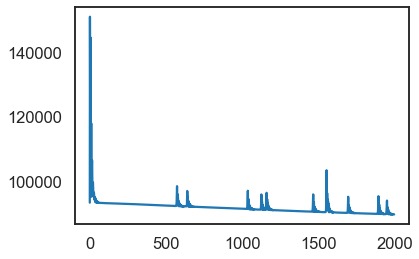

In [59]:
plt.plot(losses[4000:])

# check prediction

In [60]:
z = model.most_likely_states(data)
x_predict_arr = k_step_prediction(model, z, data)

In [61]:
[sum(z==k) for k in range(K)]

[4990, 0, 10, 0, 0]

([], <a list of 0 Text yticklabel objects>)

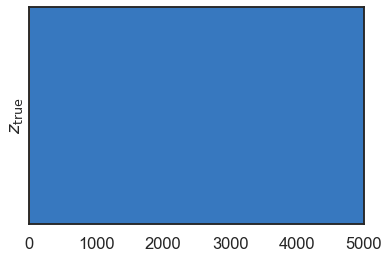

In [62]:
T = 5000
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors))
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

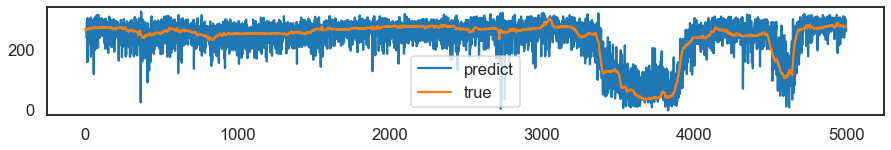

In [65]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

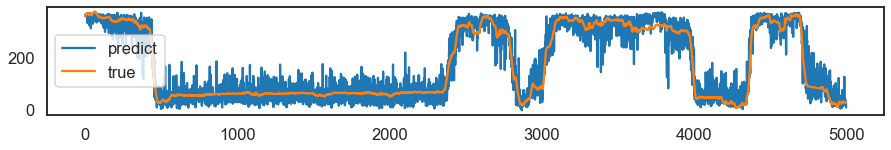

In [66]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,3], label='predict')
plt.plot(data[:,3].numpy(), label='true')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,2], label='predict')
plt.plot(data[:,2].numpy(), label='true')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[2000:2200,0], label='predict')
plt.plot(data[2000:2200,0].numpy(), label='true')
plt.legend()
plt.show()

may want to encode tihs "shift" behavior

In [ ]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(z[None,slc], aspect="auto")

In [ ]:
model.transition_matrix

In [ ]:
import numpy.random as npr
Pi = 2 * np.eye(K) + .05 * npr.rand(K, K)
torch.nn.Softmax(dim=1)(torch.tensor(Pi))

see why the hidden states collapse

In [ ]:
samples_z, samples_x = model.sample(1500)

In [ ]:
plot_2_mice(samples_x)

In [ ]:
plt.figure(figsize=(20,2))
plot_4_traces(samples_x)

In [ ]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(samples_z[None,slc], aspect="auto")

# try to see how different states like

In [ ]:
def plot_quiver(XYs, dXYs, mouse, other_mouse_loc=None):
    if mouse == 'virgin':
        i = 0
        j = 1
    elif mouse == 'mother':
        i = 2
        j = 3
        
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].quiver(XYs[:,i], XYs[:,j], dXYs[:, 0, i], dXYs[:, 0, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[0].set_title('K=0')

    axs[1].quiver(XYs[:,i], XYs[:,j], dXYs[:, 1, i], dXYs[:, 1, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[1].set_title('K=1')

   
    if other_mouse_loc is not None:
        axs[0].plot(*other_mouse_loc, 'ro')
        axs[1].plot(*other_mouse_loc, 'ro')
    

    plt.tight_layout()

In [ ]:
mus = tran.transform(data)
p_data = SigmoidNormal(mus=mus, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

In [ ]:
samples = p_data.sample((100,))

In [ ]:
d_data = torch.mean(samples, dim=0).numpy() - data.numpy()[:,None]

In [ ]:
mean = torch.mean(samples, dim=0).numpy()

In [ ]:
plot_quiver(data, d_data, 'virgin', other_mouse_loc=None)

In [ ]:
plot_quiver(data, d_data, 'mother', other_mouse_loc=None)

In [ ]:
nest = np.array([270, 330])

In [ ]:
XX, YY = np.meshgrid(np.linspace(0, 320, 20), 
                     np.linspace(0, 370, 25))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (100,2) grid values

XY_other = np.tile(nest[None,], (500,1))

XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

mus_virgin = tran.transform(torch.tensor(XY_virgin, dtype=torch.float64))
p_virgin = SigmoidNormal(mus=mus_virgin, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

mus_mother = tran.transform(torch.tensor(XY_mother, dtype=torch.float64))
p_mother = SigmoidNormal(mus=mus_mother, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

samples_virgin = p_virgin.sample((100,))
samples_mother = p_mother.sample((100,))

dXY_virgin = torch.mean(samples_virgin, dim=0).numpy() - XY_virgin[:, None]
dXY_mother = torch.mean(samples_mother, dim=0).numpy() - XY_mother[:, None]

In [ ]:
plot_quiver(XY_virgin, dXY_virgin, 'virgin', nest)

In [ ]:
plot_quiver(XY_mother, dXY_mother, 'mother', nest)

In [ ]:
# another experiment to add: fixing the trajectory of one mouse, and generating the other? does this make sense?

train for another 1000 iters

In [ ]:
num_iters = 1000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [ ]:
plt.plot(losses[5500:])

In [ ]:
num_iters = 2000

pbar = tqdm(total=num_iters, file=sys.stdout)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [ ]:
plt.plot(losses[6000:])

In [ ]:
z = model.most_likely_states(data)
x_predict_arr = k_step_prediction(model, z, data)

plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

In [ ]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(z[None,slc], aspect="auto")

In [ ]:
samples_z, samples_x = model.sample(1000)

In [ ]:
plt.plot(samples_x[:,0], samples_x[:,1], label='virgin')
plt.plot(samples_x[:,2], samples_x[:,3], label='mother')
plt.legend();

In [ ]:
plt.plot(samples)

In [ ]:
# need to look into why

In [ ]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(samples_z[None,slc], aspect="auto")

In [ ]:
torch.nn.Softmax(dim=1)(model.Pi)

In [ ]:
samples_z, samples_x = model.sample(1000)

In [ ]:
samples_z = model.sample_z(1000)

In [ ]:
torch.nn.Softmax(dim=0)(model.pi0)

issue: transition matrix collapse.. try to add more states?

What it means is that: there is only one state, and one dynamic... so it can be fit well.... and probably over-fitted.
